# **TSLA Stock Kalman Filtering Techniques**

In [48]:
import numpy as np
import pandas as pd
from math import sqrt
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [49]:
start = datetime(2020, 1, 1)
end = datetime(2023, 4, 28)

TSLA = yf.download('TSLA', start = start, end = end)
TSLA.reset_index(inplace = True)

[*********************100%***********************]  1 of 1 completed


In [50]:
TSLA

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500
...,...,...,...,...,...,...,...
831,2023-04-21,164.800003,166.000000,161.320007,165.080002,165.080002,123539000
832,2023-04-24,164.649994,165.649994,158.610001,162.550003,162.550003,140006600
833,2023-04-25,159.820007,163.470001,158.750000,160.669998,160.669998,121999300
834,2023-04-26,160.289993,160.669998,153.139999,153.750000,153.750000,153364100


In [51]:
# 1. Kalman_Filter Class

def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = param0[0]
    T = param0[1]
    H = param0[2]
    Q = param0[3]
    # "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1:
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q
        else:
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            Likelihood = np.sum(KF_Dens[1:-1])
            return Likelihood

def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1:
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q
        else:
            # "Please fill this part."
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q


            u_smooth = np.zeros(S)
            P_smooth = np.zeros(S)
            u_smooth[S-1] = u_update[S-1]
            P_smooth[S-1] = P_update[S-1]
    for  t in range(S-1,0,-1):

        u_smooth[t-1] = u_update[t] +P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]- T*u_update[t])
        P_smooth[t-1] = P_update[t] + (P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_update[t])/P_update[t]*T*P_update[t])

    u_smooth = u_smooth[0:-1]
    return u_smooth

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1


/var/folders/p6/09_jyd9922d_qcbtp4sgzp3h0000gn/T/ipykernel_55114/1343335637.py:5: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(Kalman_Filter, param0, method = 'BFGS', options = {'xtol': 1e-8, 'disp': True})


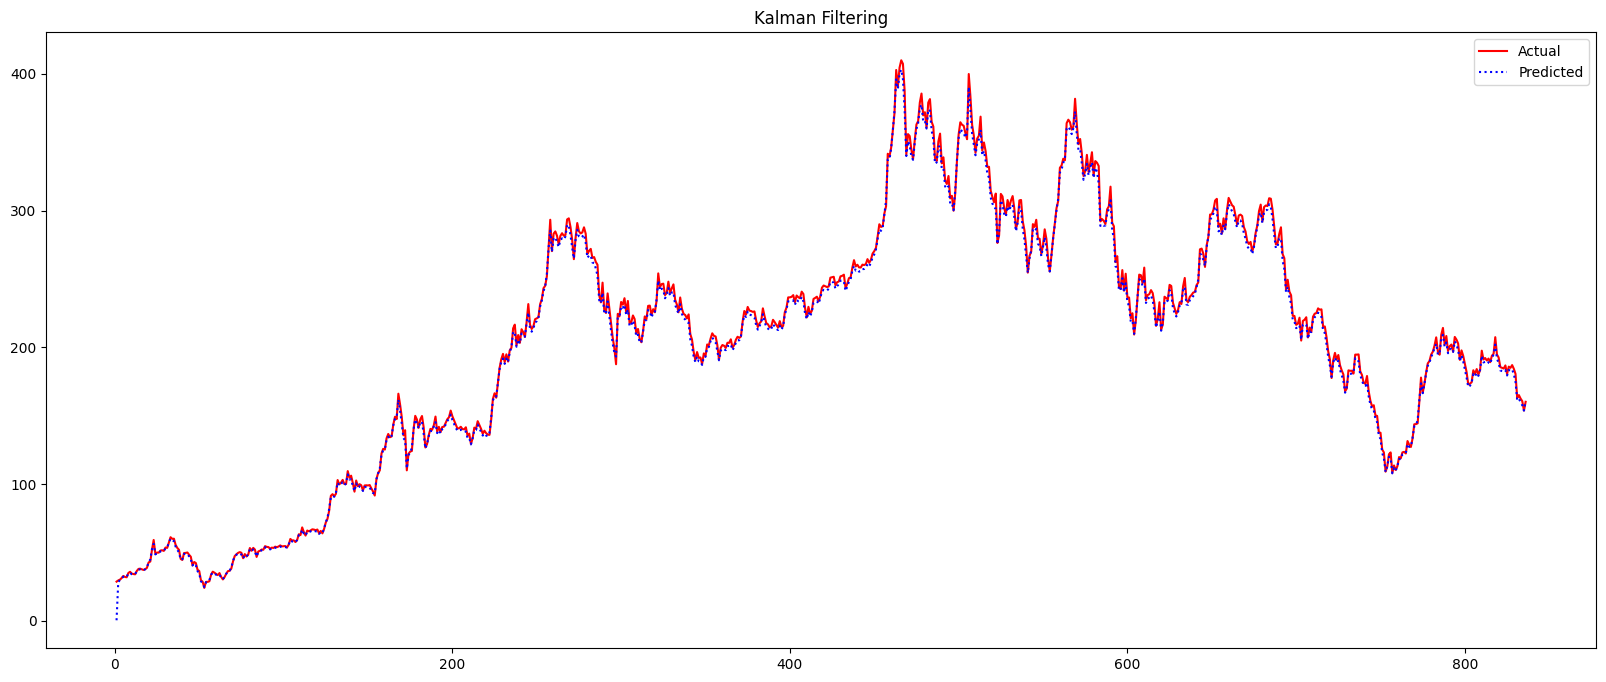

In [57]:
Y = TSLA['Adj Close'].values
T = Y.size

param0 = np.array([0.78, 1.25, 160*np.std(Y), 920*np.std(Y)])
param_star = minimize(Kalman_Filter, param0, method = 'BFGS', options = {'xtol': 1e-8, 'disp': True})
y_pred = Kalman_Smoother(param_star.x, Y)
timevec = np.linspace(1, T, T)

fig = plt.figure(figsize = (20, 8))
plt.plot(timevec, Y, 'r-', label = 'Actual')
plt.plot(timevec, y_pred, 'b:', label = 'Predicted')
plt.legend(loc = 'upper right')
plt.title("Kalman Filtering")
plt.show()

In [58]:
results = pd.DataFrame({'Actual': list(Y), 'Predicted': list(y_pred), 'Date': TSLA['Date'], 'Open': TSLA['Open'], 'Close': TSLA['Close']})
results.set_index('Date', inplace = True)
results.head()

,Actual,Predicted,Open,Close
Date,,,,
2020-01-02,28.684000,0.407946,28.299999,28.684000
2020-01-03,29.534000,28.123841,29.366667,29.534000
2020-01-06,30.102667,29.986442,29.364668,30.102667
2020-01-07,31.270666,31.182029,30.760000,31.270666
2020-01-08,32.809334,32.273593,31.580000,32.809334



**Long Short Day trading:**

*   if predicted > yesterdays close, buy and sell at end of day
*   if predicted < yesterdays close, sell and buy at end of day



0 Sell at Open 9989.9 - 353 17
0 Buy Back at Close 10142.45 0


1 Sell at Open 10131.5 - 345 12
1 Buy Back at Close 10201.23 0


2 Buy at Open 10189.54 347 26
2 Sell at Close 10471.63 0


3 Buy at Open 10458.4 340 27
3 Sell at Close 10659.03 0


4 Buy at Open 10642.46 337 28
4 Sell at Close 11084.75 0


5 Sell at Open 11068.76 - 334 13
5 Buy Back at Close 10730.84 0


6 Buy at Open 10727.86 334 20
6 Sell at Close 10666.81 0


7 Buy at Open 10659.6 324 29
7 Sell at Close 11365.98 0


8 Buy at Open 11356.89 313 33
8 Sell at Close 11257.6 0


9 Sell at Open 11230.91 - 318 23
9 Buy Back at Close 11015.2 0


10 Sell at Open 10994.17 - 334 26
10 Buy Back at Close 11459.71 0


11 Sell at Open 11438.15 - 338 24
11 Buy Back at Close 11527.27 0


12 Buy at Open 11524.1 326 36
12 Sell at Close 11928.48 0


13 Buy at Open 11895.31 312 5
13 Sell at Close 11851.85 0


14 Sell at Open 11849.25 - 315 26
14 Buy Back at Close 12042.2 0


15 Sell at Open 12021.27 - 316 30
15 Buy Back at Close 11928.87 0


<Axes: title={'center': 'Total Amount'}>

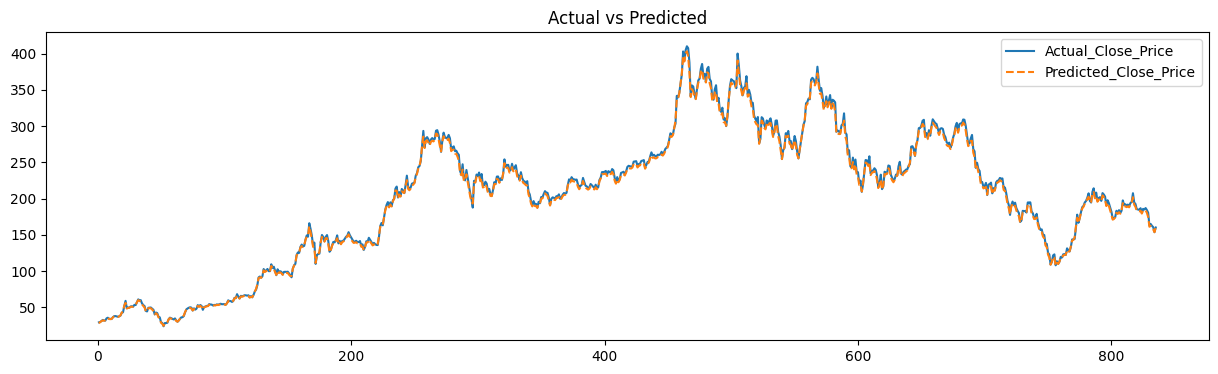

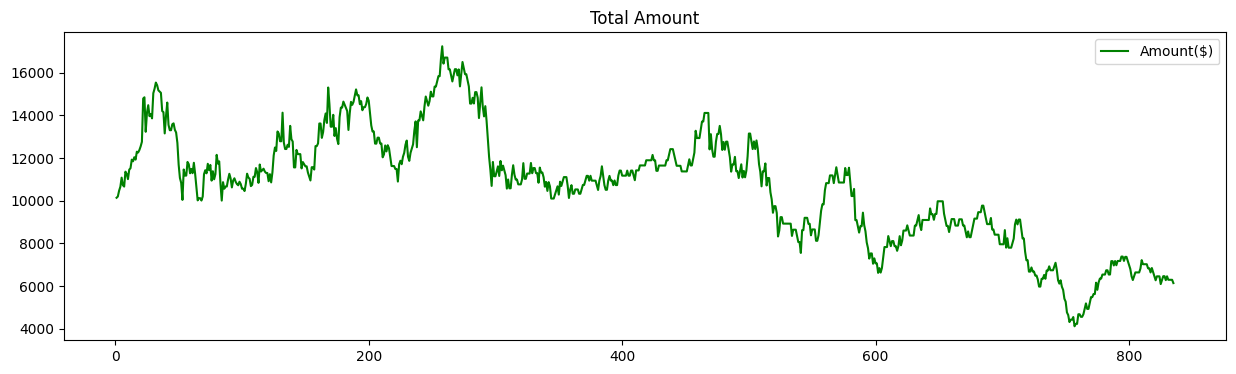

In [59]:
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results) - 1):
    if results['Predicted'][i] > results['Actual'][i-1]:
        action.append('Buy at Open & Sell at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i, 'Buy at Open', round(portfolio, 2), stocks, round(balance, 2))

        # action.append('Sell at End')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, 'Sell at Close', round(amount, 2), balance)
        Amount.append(amount)
        Portfolio.append(round(portfolio, 5))

    else:
        action.append('Sell at Open & Bull at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i, 'Sell at Open', round(portfolio, 2), '-', stocks, round(balance, 2))

        # action.append('Buy at Close')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, 'Buy Back at Close', round(amount, 2), balance)
        Amount.append(amount)
        Portfolio.append(round(portfolio, 5))
    print('\n')

Strategy_Result = pd.DataFrame({'Actual_Close_Price':TSLA.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': TSLA.Date[1:],
                                 'Action':  action,
                                 # 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                })

Strategy_Result.head()
Strategy_Result[['Actual_Close_Price', 'Predicted_Close_Price']].loc[0:].plot(figsize = (15, 4), style = ['-', '--'], title = 'Actual vs Predicted')
Strategy_Result[['Amount($)']].loc[0:].plot(figsize = (15, 4), style = ['-g'], title = 'Total Amount')